In [110]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score # for measuring model
from sklearn.metrics import roc_curve
from collections import Counter

In [111]:
## From Week 3 code to train the model

# df = pd.read_csv('data-week-3.csv')
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv", sep = ",")

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [112]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [113]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [114]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter = 10000)
# model = LogisticRegression(solver='lbfgs', max_iter = 1000)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,10000
,multi_class,'deprecated'


In [115]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [116]:
## 4.2 Accuracy and dummy model

In [117]:
len(y_val)

1409

In [118]:
# correct predictions
(y_val == churn_decision).sum()

np.int64(1132)

In [119]:
# correct preductinos/ length of y_val
1132/1409

0.8034066713981547

In [120]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [121]:
# play with different thresholds to see which is the most accurate
#linspace(first value, last value, array size)

thresholds = np.linspace(0, 1, 21)

# list to populate with threshold results
scores = []

for t in thresholds:
    churn_decision = (y_pred >= t)
    #score = (y_val == churn_decision).mean()
    score = accuracy_score(y_val, y_pred >= t) # does the same as the line above
    print ('%.2f %.3f' % (t, score)) # threshold 2 dec places, score is with 3 decimal places
    scores.append(score)

    # note for 1, assuming everyone churns, the accuracy is 72.6%. For 0.5 the accuracy is 80%.
    # Is it worth building a model for just 7% increase in accuracy?

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.661
0.20 0.703
0.25 0.734
0.30 0.758
0.35 0.765
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.801
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


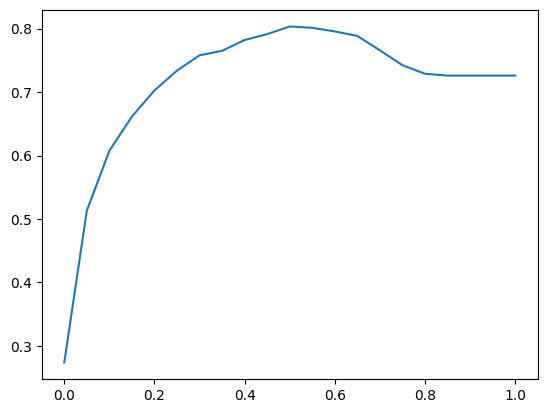

In [122]:

# plotting the scores
plt.plot(thresholds, scores)

In [123]:
# checking how many are true/ false. all False in this case
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [124]:
## Class imbalance?

In [125]:
1 - y_val.mean()

np.float64(0.7260468417317246)

1 - y_val.mean()

In [126]:
## 4.3 Confusion table

In [127]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [128]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [129]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [130]:
# look at first 5 records to verify
# comparing predicted and actual positive.
predict_positive[:5]

array([False, False, False,  True, False])

In [131]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[920, 103],
       [174, 212]])

In [132]:
# change to percents so you can see the proportion
(confusion_matrix / confusion_matrix.sum()).round(2) 

array([[0.65, 0.07],
       [0.12, 0.15]])

In [133]:
## Precision and Recall
# Precision - what fraction of positive predictions are correct? eg. of all the predicted chur, how many were correc? tp and fp
# Recall - fraction of correctly identified positive examples. eg. of all the churned, how many were caught? tp and fn

In [134]:
(tp + tn) / (tn + tp + fn + fp)

np.float64(0.8034066713981547)

In [135]:
# precision
p = tp/ (tp + fp)
p

np.float64(0.6730158730158731)

In [136]:
#recall
r = tp/ (tp + fn)
r

np.float64(0.5492227979274611)

In [137]:
## ROC Curves

In [138]:
#TPR and FPR
# Part of ROC Curves
# same as recall value
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [139]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10068426197458455)

In [140]:
scores = []

thresholds = np.linspace(0, 1, 101) # 101 confusion matrices for different threshold

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    scores.append((t, tp, fp, fn, tn)) # t is threshold

In [141]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [142]:
df_scores[::10] #every 10th record

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,533,20,490,0.948187,0.521017
20,0.2,339,372,47,651,0.878238,0.363636
30,0.3,292,247,94,776,0.756477,0.241447
40,0.4,254,175,132,848,0.658031,0.171065
50,0.5,212,103,174,920,0.549223,0.100684
60,0.6,151,53,235,970,0.391192,0.051808
70,0.7,69,13,317,1010,0.178756,0.012708
80,0.8,4,0,382,1023,0.010363,0.000000
90,0.9,0,0,386,1023,0.000000,0.000000


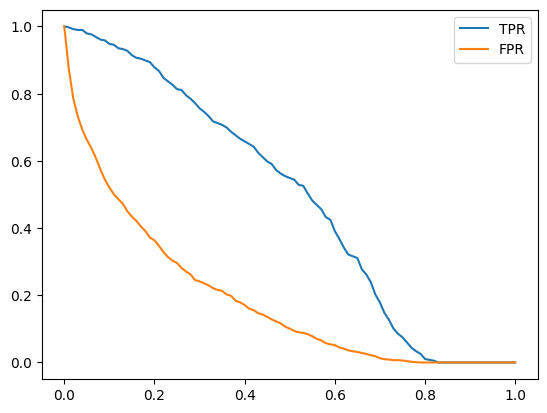

In [143]:
plt.plot(df_scores.threshold, df_scores['tpr'], label= 'TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR')
plt.legend()
# want to keep FPR as low as possible but TPR as high as possible

In [144]:
# Random Model
# Part of ROC curves
# compares result to a coin-toss

In [145]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size = len(y_val))

In [146]:
y_rand

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, ...,
       7.73916250e-01, 3.34276405e-01, 8.89982208e-02], shape=(1409,))

In [147]:
((y_rand >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [148]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn'] # make sure these are in the right order
    df_scores = pd.DataFrame(scores, columns = columns)
    
    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

    return df_scores

In [149]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [150]:
df_rand[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.902248
20,0.2,307,822,79,201,0.795337,0.803519
30,0.3,276,724,110,299,0.715026,0.707722
40,0.4,237,624,149,399,0.613990,0.609971
50,0.5,202,518,184,505,0.523316,0.506354
60,0.6,161,409,225,614,0.417098,0.399804
70,0.7,121,302,265,721,0.313472,0.295210
80,0.8,78,206,308,817,0.202073,0.201369
90,0.9,40,101,346,922,0.103627,0.098729


<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

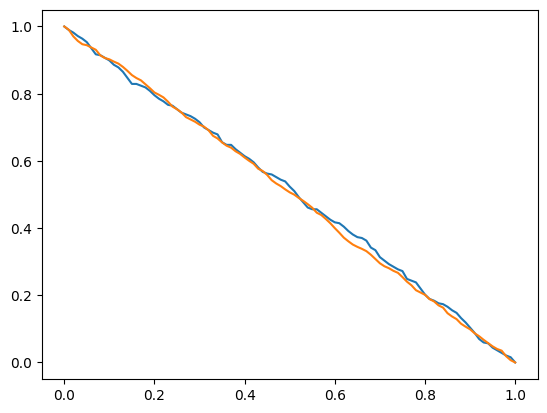

In [151]:
plt.plot(df_rand.threshold, df_rand['tpr'], label = 'TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label = 'FPR')
plt.legend
# bottom axis probability of negative. Eg. Non churning. Side axis positive result eg. probabilty of churning

In [152]:
## Ideal model
## Model that predicts correctly for everyone

In [153]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [154]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [155]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [156]:

accuracy_score(y_ideal, y_ideal_pred >= 0.726) # pred is greater than 1 - y_val.mean()

1.0

In [157]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


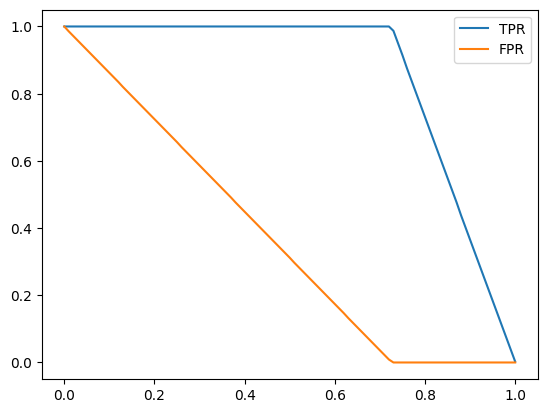

In [158]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR')
plt.legend()

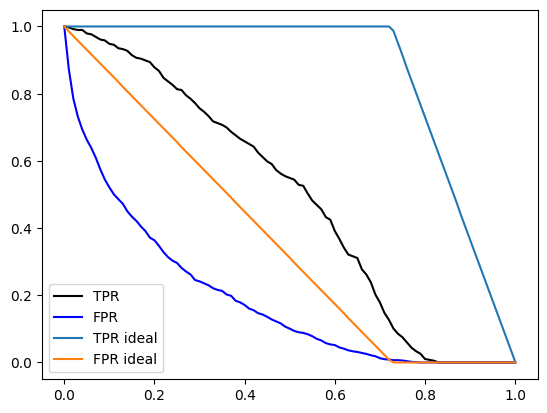

In [159]:
plt.plot(df_scores.threshold, df_scores['tpr'], label = 'TPR', color = 'black')
plt.plot(df_scores.threshold, df_scores['fpr'], label = 'FPR', color = 'blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label = 'TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label = 'FPR ideal')

plt.legend()

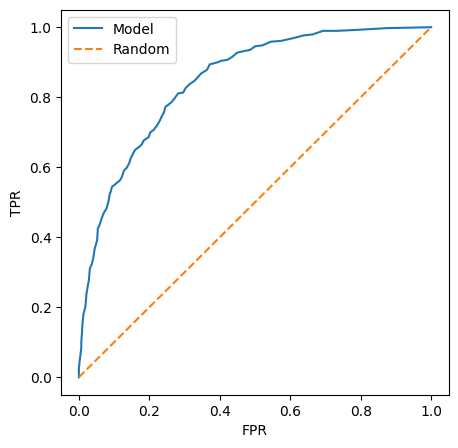

In [160]:
plt.figure(figsize = (5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label= 'Model')
plt.plot([0,1], [0,1], label = 'Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()